# Kolkata - A Scope for Food Lovers and Businesses

## Table of Contents

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem

This project aims to identify which venues/restaurants are a person more likely to visit in Kolkata and on what grounds ideally, which can be used by upcoming visitors as well as restaurateurs in their respective fields. 

A visitor is highly subjective towards reviews/ratings and price points and other attributes. Also, most visitors would prefer to stay in a centrally located spot in the city and best if the best restaurants are right across the corner.

Restaurants/food-based service providers/hoteliersutilise data for identifying locations or price points which can attract more footfall and therefore generate more profit for their businesses. Aggregator-based-online-service providers can also avail data to suggest new visitors with updated information on the same. 

Hence, we will identify areas that are fit for various individuals based on the information collected from two APIs and thereby do a cluster analysis to draw useful conclusions.

## Data

We will use data from two different APIs. 

a. Foursquare API to fetch venues in Kolkata starting from the city center to a stretch of 4 Kilometres in all directions
b. Zomato API to get detailed information on the venues such as address, rating, price range etc

Kolkata
Kolkata is a metropolitan city and the heart of the city lies in the Esplanade area which is where most of the tourists prefer staying. 

We have googled the latitude-longitude of Kolkata and will directly supply the same for folium maps as well as for the APIs.

In [1]:
# import libraries
import requests
import pandas as pd
import numpy as np
import random
from IPython.display import Image 
from IPython.core.display import HTML 
    
from pandas.io.json import json_normalize

print('Libraries imported.')

Libraries imported.


The geograpical coordinates of Kolkata are 22.572645, 88.363892

We will use the folium library to plot a zoomed map of Kolkata with a marker at exactly the center point.

In [15]:
# install folium
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
kollatitude = '22.572645'
kollongitude = '88.363892'
print('The geograpical coordinates of Kolkata are {}, {}.'.format(kollatitude, kollongitude))

The geograpical coordinates of Kolkata are 22.572645, 88.363892.


In [19]:
kollatitude=float(kollatitude)
kollongitude=float(kollongitude)

In [16]:
import folium

kolkata_map = folium.Map(location = [kollatitude, kollongitude], zoom_start = 13)
folium.Marker([kollatitude, kollongitude]).add_to(kolkata_map)
kolkata_map

### Foursquare API

Using the API, we fetch data for all the venues which lie within a radius of 4 Kilometres from the city centre

In [4]:
CLIENT_ID = 'MJZRSICI1WUB24HW4G5XJ13OH1HUTKZPHPFMSQTJOGYEFIIK' # your Foursquare ID
CLIENT_SECRET = '2GN1O053KYY4SSEVHWKX2JIBUEOL0R4GD4TQEQMDNNLQNCVR' # your Foursquare Secret
VERSION = '20180605'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100

We define the get_category_type method to get the correct category for each venue.

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.

We will set the radius as 4 Kilometers.

The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        kollatitude, 
                                                                        kollongitude, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))


Total 100 venues fetched within a total radius of 4.0 Km
Total 29 venues fetched within a total radius of 4.0 Km

Total 129 venues fetched


### Zomato API

Zomato Developers has its search API that can be used to access details on a venue such as latitude, longitude, queries, ratings etc. For this, i have created an account in Zomato which has given me a user key

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

The query will be the name of the venue.
The start defines from what offset we want to start, so we'll keep it at 0.
The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
We will supply the latitude and longitude values.
We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [7]:
headers = {'user-key': '583558add42c5ddc5ca3db3daf87b327'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [8]:
venues_information

[['The Bar - The Oberoi Grand',
  '22.5606509835',
  '88.3515113220',
  3300,
  4,
  '3.8',
  'The Oberoi Grand, 15, Jawaharlal Nehru Road, New Market Area, Kolkata'],
 ['The Tea Lounge - The Lalit Great Eastern',
  '22.5679531486',
  '88.3500418067',
  1500,
  3,
  '3.7',
  'The Lalit Great Eastern, 1 - 3, Old Court House Street, Dalhousie Square, Esplanade, Kolkata'],
 ['Blue And Beyond',
  '22.5590873999',
  '88.3532292768',
  1600,
  3,
  '3.9',
  'The Lindsay, 8A & 8B, Lindsay Street, New Market Area, Kolkata'],
 ['Shree Balaji South Indian Mess Veg',
  '22.5701528559',
  '88.3266398683',
  200,
  1,
  '3.5',
  'Shop 11, Block A2, 106 Kiran Chandra Singha Road, Gangesh Garden, Shibpur, Howrah'],
 ['Anand Restaurant',
  '22.5674797658',
  '88.3549512550',
  500,
  2,
  '4.1',
  '19, C.R. Avenue, Near Dalhousie Square Area, Chandni Chowk, Kolkata'],
 ['Indian Coffee House',
  '22.5760877107',
  '88.3639356494',
  300,
  1,
  '3.6',
  '15, Bankim Chatterjee Street, College Street, Ko

In [11]:
type(venues_information)

list

In [12]:
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

In [13]:
zomato_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,The Bar - The Oberoi Grand,22.5606509835,88.3515113220,3300.0,4.0,3.8,"The Oberoi Grand, 15, Jawaharlal Nehru Road, N..."
1,The Tea Lounge - The Lalit Great Eastern,22.5679531486,88.3500418067,1500.0,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous..."
2,Blue And Beyond,22.5590873999,88.3532292768,1600.0,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark..."
3,Shree Balaji South Indian Mess Veg,22.5701528559,88.3266398683,200.0,1.0,3.5,"Shop 11, Block A2, 106 Kiran Chandra Singha Ro..."
4,Anand Restaurant,22.5674797658,88.3549512550,500.0,2.0,4.1,"19, C.R. Avenue, Near Dalhousie Square Area, C..."
5,Indian Coffee House,22.5760877107,88.3639356494,300.0,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ..."
6,Carpe Diem,22.5521092663,88.3526039869,1000.0,3.0,4.4,"18M, Park Street Area, Kolkata"
7,Kareem's,22.5538791454,88.3543313295,1200.0,3.0,4.4,"55 B, Mirza Ghalib Street, Park Street Area, K..."
8,"Sanwaria ""Ghar Ko Khano""",22.5864543632,88.3575110883,300.0,1.0,0,"17th, 5 Thakur Lane, Bara Bazar, Kolkata"
9,Indian Coffee House,22.5760877107,88.3639356494,300.0,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ..."


## Data Cleaning

Data from multiple resources might not always align. Therefore, it is required to combine the data correctly. 

We will first plot the Foursquare data on the map. We will then match data basis similar latitudes and longitudes and combine them into one dataset. Also, the remaining mismatched values have to be removed from the dataset. 

In [17]:

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(kolkata_map)  

kolkata_map

In [21]:
zomato_venues.shape

(129, 7)

Now, in order to extract data and use it for our analysis, we need to combine both datasets using latitude and longitude exactness or proximity. Data should be such that it should also consider datapoints with latitude or longitudinal difference of 0.0004

In [22]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [23]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [24]:
final_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
final_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Lalit Great Eastern Hotel,Hotel,22.5680,88.3500,The Tea Lounge - The Lalit Great Eastern,22.5680,88.3500,1500.0,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",0.0000,0.0000
1,Blue & Beyond,Pub,22.5591,88.3533,Blue And Beyond,22.5591,88.3532,1600.0,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",0.0000,-0.0001
2,Anand Restaurant,South Indian Restaurant,22.5673,88.3549,Anand Restaurant,22.5675,88.3550,500.0,2.0,4.1,"19, C.R. Avenue, Near Dalhousie Square Area, C...",0.0002,0.0001
3,Indian Coffee House,Café,22.5762,88.3640,Indian Coffee House,22.5761,88.3639,300.0,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",-0.0001,-0.0001
4,Peter Cat,Indian Restaurant,22.5524,88.3525,Carpe Diem,22.5521,88.3526,1000.0,3.0,4.4,"18M, Park Street Area, Kolkata",-0.0003,0.0001
5,Arsalan,Mughlai Restaurant,22.5539,88.3541,Kareem's,22.5539,88.3543,1200.0,3.0,4.4,"55 B, Mirza Ghalib Street, Park Street Area, K...",0.0000,0.0002
6,College Street Market,Bookstore,22.5763,88.3636,Indian Coffee House,22.5761,88.3639,300.0,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",-0.0002,0.0003
7,Flurys,Bakery,22.5528,88.3526,WOW! China,22.5529,88.3526,650.0,2.0,3.9,"19-57, Park Street Area, Kolkata",0.0001,0.0000
8,Bar-B-Q,BBQ Joint,22.5531,88.3526,Oasis,22.5532,88.3524,900.0,2.0,3.8,"33, Park Street, Park Street Area, Kolkata",0.0001,-0.0002
9,Raj's Spanish Cafe,Café,22.5583,88.3542,Raj Spanish Cafe,22.5584,88.3542,600.0,2.0,4.1,"7, Ground Floor, Sudder Street, New Market Are...",0.0001,0.0000


This resulted in 59 rows of data.
Post this, it was found in the dataframe that

i. There are venues like multiplexes which have restaurants inside them

ii. Two locations are so close that they share the same latitude and longitude values

iii. There were one or two duplicate data entries

While it was ok to keep i, it did not make any sense to keep ii and iii and therefore, the corresponding rows were dropped from the dataframe. 


In [28]:
final_venues = final_venues.drop([4, 5, 7, 8, 10, 12, 18, 27, 29, 33, 37, 38, 44, 47, 49, 55, 58, 59]).reset_index(drop = True)

In [31]:
final_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Lalit Great Eastern Hotel,Hotel,22.5680,88.3500,The Tea Lounge - The Lalit Great Eastern,22.5680,88.3500,1500.0,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",0.0000,0.0000
1,Blue & Beyond,Pub,22.5591,88.3533,Blue And Beyond,22.5591,88.3532,1600.0,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",0.0000,-0.0001
2,Anand Restaurant,South Indian Restaurant,22.5673,88.3549,Anand Restaurant,22.5675,88.3550,500.0,2.0,4.1,"19, C.R. Avenue, Near Dalhousie Square Area, C...",0.0002,0.0001
3,Indian Coffee House,Café,22.5762,88.3640,Indian Coffee House,22.5761,88.3639,300.0,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",-0.0001,-0.0001
4,College Street Market,Bookstore,22.5763,88.3636,Indian Coffee House,22.5761,88.3639,300.0,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",-0.0002,0.0003
5,Raj's Spanish Cafe,Café,22.5583,88.3542,Raj Spanish Cafe,22.5584,88.3542,600.0,2.0,4.1,"7, Ground Floor, Sudder Street, New Market Are...",0.0001,0.0000
6,Blue Sky Cafe,Restaurant,22.5582,88.3529,Blue Sky Cafe,22.5582,88.3530,650.0,2.0,4.1,"3, Sudder Street, New Market Area, Kolkata",0.0000,0.0001
7,Kasturi Restaurant (Dhakai Bengali Cuisine),Asian Restaurant,22.5568,88.3549,Kasturi Restaurant,22.5568,88.3549,500.0,2.0,4.0,"7A, Mustaque Ahmed Street, New Market Area, Ko...",0.0000,0.0000
8,Cafe Coffee Day,Café,22.5776,88.3904,Cafe Coffee Day,22.5778,88.3904,700.0,2.0,3.7,"P-183 A, CIT Road, Scheme 6M, Kankurgachhi, Ko...",0.0002,0.0000
9,Amber,Indian Restaurant,22.5675,88.3518,Amber,22.5674,88.3518,1200.0,3.0,3.8,"11, Waterloo Street, Esplanade, Kolkata",-0.0001,0.0000


Let us compute the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [32]:
final_venues['average_price'] = final_venues['price_for_two']/2
final_venues = final_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

The final dataset

In [33]:
final_venues

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Hotel,The Tea Lounge - The Lalit Great Eastern,22.5680,88.3500,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",750.0
1,Pub,Blue And Beyond,22.5591,88.3532,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",800.0
2,South Indian Restaurant,Anand Restaurant,22.5675,88.3550,2.0,4.1,"19, C.R. Avenue, Near Dalhousie Square Area, C...",250.0
3,Café,Indian Coffee House,22.5761,88.3639,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",150.0
4,Bookstore,Indian Coffee House,22.5761,88.3639,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",150.0
5,Café,Raj Spanish Cafe,22.5584,88.3542,2.0,4.1,"7, Ground Floor, Sudder Street, New Market Are...",300.0
6,Restaurant,Blue Sky Cafe,22.5582,88.3530,2.0,4.1,"3, Sudder Street, New Market Area, Kolkata",325.0
7,Asian Restaurant,Kasturi Restaurant,22.5568,88.3549,2.0,4.0,"7A, Mustaque Ahmed Street, New Market Area, Ko...",250.0
8,Café,Cafe Coffee Day,22.5778,88.3904,2.0,3.7,"P-183 A, CIT Road, Scheme 6M, Kankurgachhi, Ko...",350.0
9,Indian Restaurant,Amber,22.5674,88.3518,3.0,3.8,"11, Waterloo Street, Esplanade, Kolkata",600.0


Venues with Zero rating must be dropped.

In [34]:
final_venues = final_venues[final_venues['rating'] != 0.0]
print("Final venues available: {}".format(final_venues.shape[0]))

Final venues available: 39


## Methodology

Once we have retrieved the final dataset for our calculation, we will analyse the data based on two most important attributes that we observe - price and ratings. 

We want to identify those venues wherein the visitor has multiple options around.

We will analyse venues basis price and ratings

And finally, we will cluster venues basis all the above information and hence recommend further course of action for prospective visitors or restauranteurs willing to do a business

# Analysis

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 22 artists>

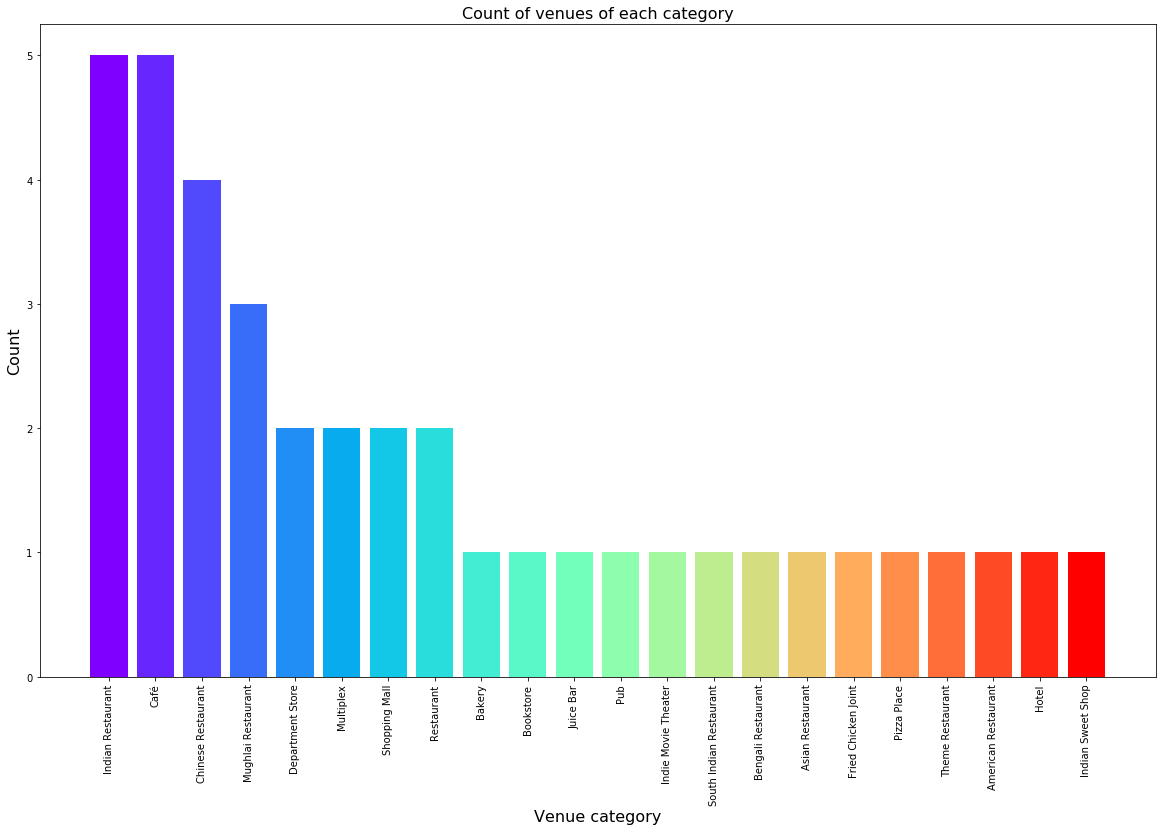

In [35]:
venue_distribution = final_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

It was observed that the most frequent visits / popularities were amongst Indian restaurants, cafes and Chinese restaurants in the decreasing order of magnitude. Therefore, a tourist/visitor looking for these cuisines would be really lucky.

### Count of Ratings

Whether a venue is to be tried out or not certainly depends on past reviews / ratings. Therefore, a bar plot was done between the ratings of different venues and their counts so as to visualize what could be the average ratings across venues.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Count of venues with given rating')

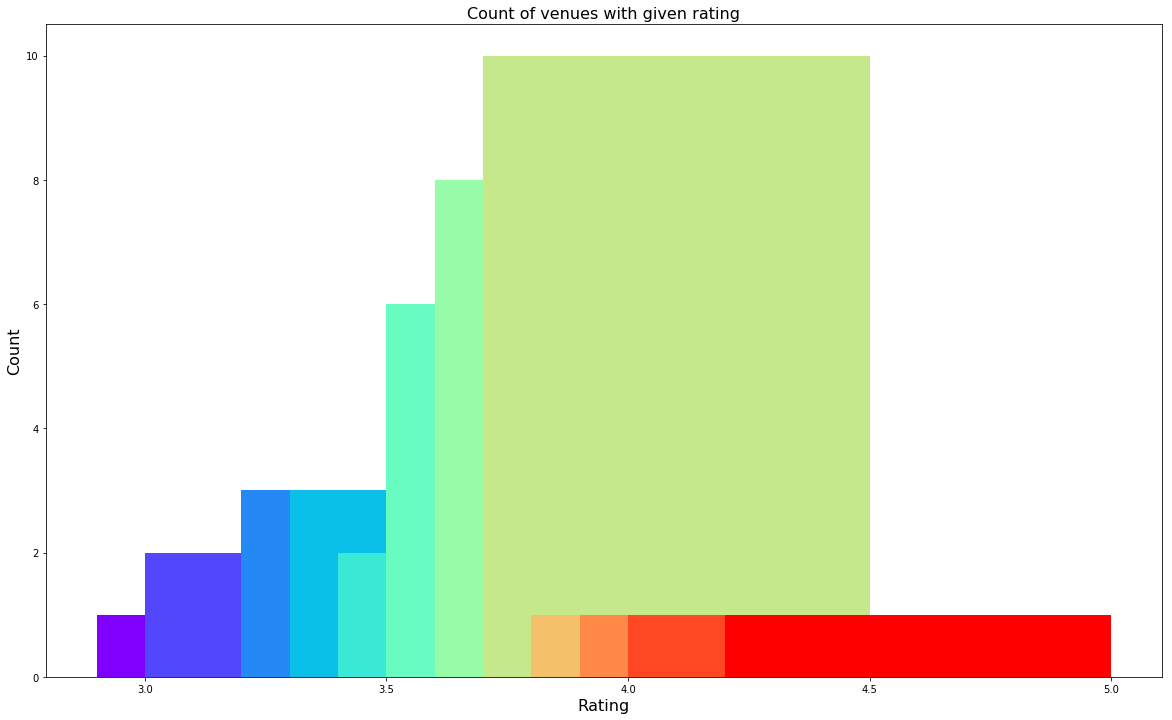

In [36]:
final_venues['rating'] = final_venues['rating'].astype(float)
rating = final_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

The ratings range from 2 to 5 on a scale of 1-5 and there is a substantial chunk that has been rated 5. Visitors might be interested to know the places with the highest ratings.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

1 to 2

2 to 3

3 to 4

4 to 5

In [37]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
final_venues['rating_bin'] = pd.cut(final_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

kolkata_map = folium.Map(location = [kollatitude, kollongitude], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(final_venues['venue'], 
                                                          final_venues['address'], 
                                                          final_venues['latitude'], 
                                                          final_venues['longitude'], 
                                                          final_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(kolkata_map)  

kolkata_map

From the map, it was observed that most of the highest rated places in dark green are closer to AJC Bose Road – Camac Street – Park Street. Therefore, a visitor should definitely try out these areas.

### Price Versus Venue
The price of a venue is perhaps one of the most important determinants of venue selection. Therefore, a scatter plot was constructed between average price points and the respective venue counts.


Text(0.5, 1.0, 'Count of venues with given average price')

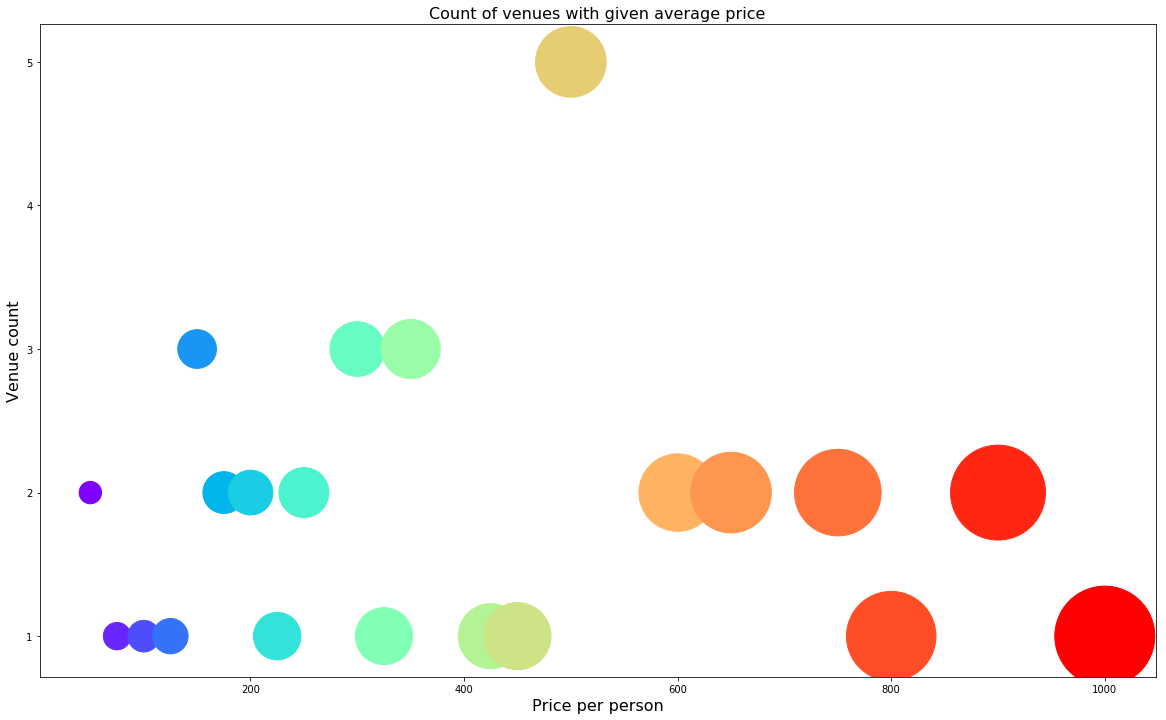

In [39]:
average_prices = final_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the above plot, it was observed that the preferred price range for restaurants was in the range of Rs 200 to Rs 600. This means that a visitor with a pocket friendly budget can tend to find a lot of options in Kolkata.

In [41]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

kolkata_map = folium.Map(location = [kollatitude, kollongitude], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(final_venues['venue'], 
                                                           final_venues['address'], 
                                                           final_venues['latitude'], 
                                                           final_venues['longitude'], 
                                                           final_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(kolkata_map)  

kolkata_map

It was observed from the above data that the earlier zone of AJC Bose Road – Camac Street – Park Street that was identified with the highest ratings also seem to have the most expensive restaurants on a relative basis. Therefore, a visitor might weigh the ratings versus price before making a judgement.
Also, restaurateurs might also analyse more as to why the price points are high in these areas. Maybe they are prime locations in the city and therefore attract exorbitant crowds but also are higher on the rental side and so a cost benefit analysis may be required before proceeding with business.


# Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them, into 3 seperate groups

In [42]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

clustering = final_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
final_venues.insert(0, 'cluster_labels', kMeans.labels_)
final_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Hotel,The Tea Lounge - The Lalit Great Eastern,22.5680,88.3500,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",750.0,Good
1,2,Pub,Blue And Beyond,22.5591,88.3532,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",800.0,Good
2,1,South Indian Restaurant,Anand Restaurant,22.5675,88.3550,2.0,4.1,"19, C.R. Avenue, Near Dalhousie Square Area, C...",250.0,Very good
3,1,Café,Indian Coffee House,22.5761,88.3639,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",150.0,Good
4,1,Bookstore,Indian Coffee House,22.5761,88.3639,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",150.0,Good


In [43]:
kolkata_map = folium.Map(location = [kollatitude, kollongitude], zoom_start = 13)
color_map = { 0: 'green', 1: 'red', 2: 'blue'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(final_venues['venue'], 
                                                        final_venues['address'], 
                                                        final_venues['cluster_labels'], 
                                                        final_venues['latitude'], 
                                                        final_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(kolkata_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(kolkata_map)

kolkata_map

Three Clusters were observed

a.	Cluster 0 (Green) is sparsely spread to the boundaries of the city centre and includes some venues. These venues have mean price range of 2.82 and rating spread around 3.97.

b.	Cluster 1 (Red) is evenly spread across the city. These venues have mean price range of 1.41 and rating spread around 3.88.

c.	Cluster 2 (Blue) is sparsely spread to the boundaries of the city centre and includes some venues. These venues have mean price range of 3.17 and rating spread around 4.08.


In [44]:
result = final_venues[final_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Indian Restaurant,Amber,22.5674,88.3518,3.0,3.8,"11, Waterloo Street, Esplanade, Kolkata",600.0,Good
1,0,Chinese Restaurant,Big Boss,22.5469,88.3879,3.0,3.9,"54C, Matheswartala Road, Tangra, Kolkata",650.0,Good
2,0,Restaurant,One Step Up,22.5530,88.3523,3.0,4.1,"18A, Park Street, Park Street Area, Kolkata",500.0,Very good
3,0,Chinese Restaurant,Golden Joy,22.5457,88.3876,3.0,4.1,"50/1, Matheswartala Tala Road, Near Gobinda Kh...",500.0,Very good
4,0,Multiplex,KK's Fusion,22.5708,88.4012,3.0,4.1,"89 C, Narkeldanga Main Road, Near Swabhumi, Ka...",600.0,Very good
5,0,Shopping Mall,Fabelle Exquisite Chocolates,22.5390,88.3657,2.0,3.4,"33, Quest Mall, Syed Amir Ali Avenue, Beck Bag...",450.0,Good
6,0,Mughlai Restaurant,Arsalan,22.5420,88.3636,3.0,4.1,"28, Circus Avenue, Near A.J.C. Bose Road Flyov...",500.0,Very good
7,0,Mughlai Restaurant,Arsalan,22.5437,88.3660,3.0,4.1,"191, Park Street, Near 7 Point Crossing, Park ...",500.0,Very good
8,0,Theme Restaurant,Kaidi Kitchen,22.5425,88.3520,3.0,4.1,"12A, Abanindra Nath, Thakur Sarani, Camac Stre...",650.0,Very good
9,0,Indian Restaurant,Charcoal Grill,22.5411,88.3680,2.0,4.0,"102 A & B, Park Street, Park Circus Area, Kolkata",425.0,Good


In [45]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 2.82 and rating spread around 3.97


In [46]:
result = final_venues[final_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,South Indian Restaurant,Anand Restaurant,22.5675,88.3550,2.0,4.1,"19, C.R. Avenue, Near Dalhousie Square Area, C...",250.0,Very good
1,1,Café,Indian Coffee House,22.5761,88.3639,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",150.0,Good
2,1,Bookstore,Indian Coffee House,22.5761,88.3639,1.0,3.6,"15, Bankim Chatterjee Street, College Street, ...",150.0,Good
3,1,Café,Raj Spanish Cafe,22.5584,88.3542,2.0,4.1,"7, Ground Floor, Sudder Street, New Market Are...",300.0,Very good
4,1,Restaurant,Blue Sky Cafe,22.5582,88.3530,2.0,4.1,"3, Sudder Street, New Market Area, Kolkata",325.0,Very good
5,1,Asian Restaurant,Kasturi Restaurant,22.5568,88.3549,2.0,4.0,"7A, Mustaque Ahmed Street, New Market Area, Ko...",250.0,Good
6,1,Café,Cafe Coffee Day,22.5778,88.3904,2.0,3.7,"P-183 A, CIT Road, Scheme 6M, Kankurgachhi, Ko...",350.0,Good
7,1,Department Store,WOW! Momo,22.5661,88.3694,1.0,3.9,"4th Floor, Big Bazaar - 1, Beliaghata Road, Se...",175.0,Good
8,1,Juice Bar,Paramount Sherbats & Syrups,22.5741,88.3645,1.0,4.4,"1/1/1D, Bankim Chatterjee Street, College Squa...",125.0,Very good
9,1,Café,The Rouge,22.5414,88.3595,1.0,4.0,"222, Circular Mansion, AJC Bose Road, Park Cir...",200.0,Good


In [47]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 1.41 and rating spread around 3.88


In [48]:
result = final_venues[final_venues['cluster_labels'] == 2]
print("Cluster 2")
result.head(10).reset_index(drop = True)

Cluster 2


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Hotel,The Tea Lounge - The Lalit Great Eastern,22.5680,88.3500,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",750.0,Good
1,2,Pub,Blue And Beyond,22.5591,88.3532,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",800.0,Good
2,2,Indian Restaurant,Trincas,22.5541,88.3514,3.0,4.1,"17, Park Street Area, Kolkata",750.0,Very good
3,2,Chinese Restaurant,Beijing,22.5465,88.3873,3.0,4.0,"77/1, Christopher Road, Tangra, Kolkata",900.0,Good
4,2,American Restaurant,TGI Fridays,22.5384,88.3513,3.0,4.2,"Forum Mall, 10/3, Elgin Road, Elgin, Kolkata",900.0,Very good
5,2,Chinese Restaurant,Mainland China,22.5371,88.3591,4.0,4.6,"3A, Uniworth House, Gurusaday Road, Ballygunge...",1000.0,Very good


In [49]:
print("These venues for cluster 2 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 2 have mean price range of 3.17 and rating spread around 4.08


# Results and Discussion

Basis the cluster analysis of venues within a certain reachable radius from the city centre, we found that the data could fit well amidst 3 clusters. 

The data for Kolkata was collected using a combination of Foursquare API and Zomato API and was matched using latitude and longitude values being common attributes. 

a.	Majority of the venues were Indian restaurants and Cafes and Chinese restaurants. A visitor coming to Kolkata with a craving for good food would surely be lucky. 

b.	A substantial amount of venues had been rated 5 on 5 which strengthens the fact that there are ample restaurants offering good quality of food and service. Most of these restaurants were in the posh zone of AJC Bose Road – Camac Street – Park Street which is frequented by business travellers, tourists and party lovers.

c.	It was observed from the above data that the earlier zone of AJC Bose Road – Camac Street – Park Street that was identified with the highest ratings also seem to have the most expensive restaurants on a relative basis. Therefore, a visitor might weigh the ratings versus price before making a judgement. Also, restaurateurs might also analyse more as to why the price points are high in these areas. Maybe they are prime locations in the city and therefore attract exorbitant crowds but also are higher on the rental side and so a cost benefit analysis may be required before proceeding with business.

d.	Cluster 0 (Green) is dominated by Indian restaurants. These are moderately priced and moderately rated. So, someone who wishes to taste good Indian food but is not too finnicky about service parameters can try out Park Circus and adjoining areas.

e.	Cluster 1 (Red) is spread across small fast food joints and bakeries and multi-cuisine restaurants which are pretty much pocket friendly but have a decent rating. So, someone who wishes to stay pretty low on pockets but enjoy a good meal can flock to these places in and around Esplanade.

f.	Cluster 2 (Blue) is dominated by Chinese restaurants which are few in number in the city but are highly rated and priced as well. So, someone who wishes to enjoy authentic Chinese can flock to these places, though there is not a single zone which has concentration of these restaurants in the city.

Apart from visitors, a restauranteur can utilise all the above information to suit his/her target audience and then plan as to what could be his mode of operation and where it wishes to operate.

An online aggregator company can use the above information to build up a good customer database by simply allowing the customer to browse venues in the city basis various search criteria like name or ratings or price.


# Conclusion

The purpose of this project was to explore the places that a person visiting Kolkata could visit. It also intended to identify venues that could help a restauranteur or an online aggregator to capitalise on their businesses. The venues were identified using Foursquare and Zomato API and plotted on the map. The maps and the clusters revealed that a visitor could either visit Park Circus for good Indian food or Esplanade and adjacent for good street food or fast food and bakery and in selected areas in the city for authentic Chinese food. However, the preferred restaurants include the ones with low price and good taste of food.